# Event Data Exploration

This notebook is designed to help you explore, parse, and visualize multi-modal sensor data collected during ADL and synchronization events for a given subject. It automates the detection of event folders, loads raw data from multiple sensor types (M5, Polar, Sensomative), and provides comparative visualizations for quality control and analysis.

**Parameters you can specify:**
- **patient_id**: The subject identifier (e.g., `"01"` for `patient01`). Change this to analyze a different subject.
- **Event selection**: The notebook automatically detects all events for the selected subject and allows you to select which event(s) to analyze.
- **Sensor data**: The notebook parses and visualizes data from all available sensors (M5 IMUs, Polar, Sensomative pressure mat) for each event.

**Key features:**
- Automatic detection of event folders for the selected subject.
- Parsing and standardization of raw sensor data from multiple modalities.
- Synchronized, comparative time-series plots for all sensors, enabling easy visual comparison.
- Modular code for easy extension to additional sensors or modalities.

---

*To get started, simply set the `patient_id` and `adl_event` variables and run the notebook. The rest is automated!*

In [ ]:
import sys
from pathlib import Path
import re

# Specify patient ID (change this to analyze different patients)
patient_id = "01"  # Extract just the number from 'patient01'

# Specify ADL event (change this to analyze different ADLs)
adl_event = "self_propulsion"  # Options below:
# synchronization
# emptywc
# resting
# phone
# computer
# arm_raises  
# eating  
# hand_cycling  
# chair_to_bed_transfer  
# bed_to_chair_transfer  
# pressure_relief  
# laying_on_back  
# laying_on_right  
# laying_on_left  
# laying_on_stomach  
# assisted_propulsion  
# self_propulsion

# Add src to sys.path for imports
sys.path.insert(0, str(Path.cwd().parent / "src"))
from utils import get_project_root, get_data_path

# Set up paths using utility functions
project_root = get_project_root()
raw_data_dir = get_data_path("raw")

# Function to extract patient ID from folder name
def extract_patient_id(folder_name):
    """Extract patient ID from folder name like '20250626_112001_patient01_0.synchronization'"""
    match = re.search(r'patient(\d+)', folder_name)
    return match.group(1) if match else None

# Function to get folders for a specific patient
def get_patient_folders(patient_id):
    """Get all folders for a specific patient ID"""
    if not raw_data_dir.exists():
        return []
    
    patient_folders = []
    for folder in raw_data_dir.iterdir():
        if folder.is_dir():
            folder_patient_id = extract_patient_id(folder.name)
            if folder_patient_id == patient_id:
                patient_folders.append(folder)
    
    return sorted(patient_folders)



# List folders for the specified patient
if raw_data_dir.exists():
    patient_folders = get_patient_folders(patient_id)
    print(f"\nFound {len(patient_folders)} folders for patient{patient_id}:")
    for folder in patient_folders:
        print(f"  - {folder.name}")
else:
    print("Raw data directory not found!")


# 1. Filter for ADL event folders
event_folders = [folder for folder in patient_folders if adl_event in folder.name]

# 2. Sort them (by name, which usually encodes the timestamp)
event_folders = sorted(event_folders)

# 3. Construct the csv_dir for each ADL event
csv_dirs = []
for folder in event_folders:
    # Find the only subdirectory inside the event folder
    subdirs = [d for d in folder.iterdir() if d.is_dir()]
    if len(subdirs) == 1:
        csv_dir = subdirs[0]
        csv_dirs.append(str(csv_dir) + "/")  # Add trailing slash for consistency
    else:
        print(f"Warning: Expected 1 subdirectory in {folder}, found {len(subdirs)}")

# 4. Print the detected csv_dirs
print(f"Detected ADL event csv directories for '{adl_event}':")
for d in csv_dirs:
    print(d)

# Now you can use csv_dirs[0], csv_dirs[1], ... in your downstream code


Found 20 folders for patient01:
  - 20250626_112001_patient01_0.synchronization
  - 20250626_112533_patient01_1.emptywc
  - 20250626_112656_patient01_2.resting
  - 20250626_112814_patient01_3.phone
  - 20250626_113039_patient01_4.computer
  - 20250626_113316_patient01_5.arm_raises
  - 20250626_113544_patient01_6.eating
  - 20250626_113809_patient01_7.hand_cycling
  - 20250626_114028_patient01_8.chair_to_bed_transfer
  - 20250626_114055_patient01_9.bed_to_chair_transfer
  - 20250626_114132_patient01_8.chair_to_bed_transfer
  - 20250626_114153_patient01_9.bed_to_chair_transfer
  - 20250626_114306_patient01_10.pressure_relief
  - 20250626_114440_patient01_11.laying_on_back
  - 20250626_114617_patient01_13.laying_on_right
  - 20250626_114727_patient01_15laying_on_left
  - 20250626_114851_patient01_16.laying_on_stomach
  - 20250626_115016_patient01_17.assisted_propulsion
  - 20250626_115123_patient01_18.self_propulsion
  - 20250626_115430_patient01_0.synchronization
Detected ADL event csv 

In [31]:
from data_preprocessing.m5_parser import parse_m5_sensor_data
from data_preprocessing.polar_parser import parse_polar_sensor_data
from data_preprocessing.sensomative_parser import parse_sensomative_sensor_data

csv_dir = csv_dirs[0] # For synchronzation/chair_to_bed_transfer/bed_to_chair_transfer, you can use csv_dirs[1] also

m5_1_csv_file = csv_dir + "M5StickC_01_data.csv"
m5_wrist_l = parse_m5_sensor_data(m5_1_csv_file)

m5_2_csv_file = csv_dir + "M5StickC_02_data.csv"
m5_wrist_r = parse_m5_sensor_data(m5_2_csv_file)

m5_3_csv_file = csv_dir + "M5StickC_03_data.csv"
m5_wheel = parse_m5_sensor_data(m5_3_csv_file)

polar_csv_file = csv_dir + "polar_acc.csv"
polar_chest = parse_polar_sensor_data(polar_csv_file)

sensomative_csv_file = csv_dir + "pressure1.csv"
sensomative_bottom = parse_sensomative_sensor_data(sensomative_csv_file)

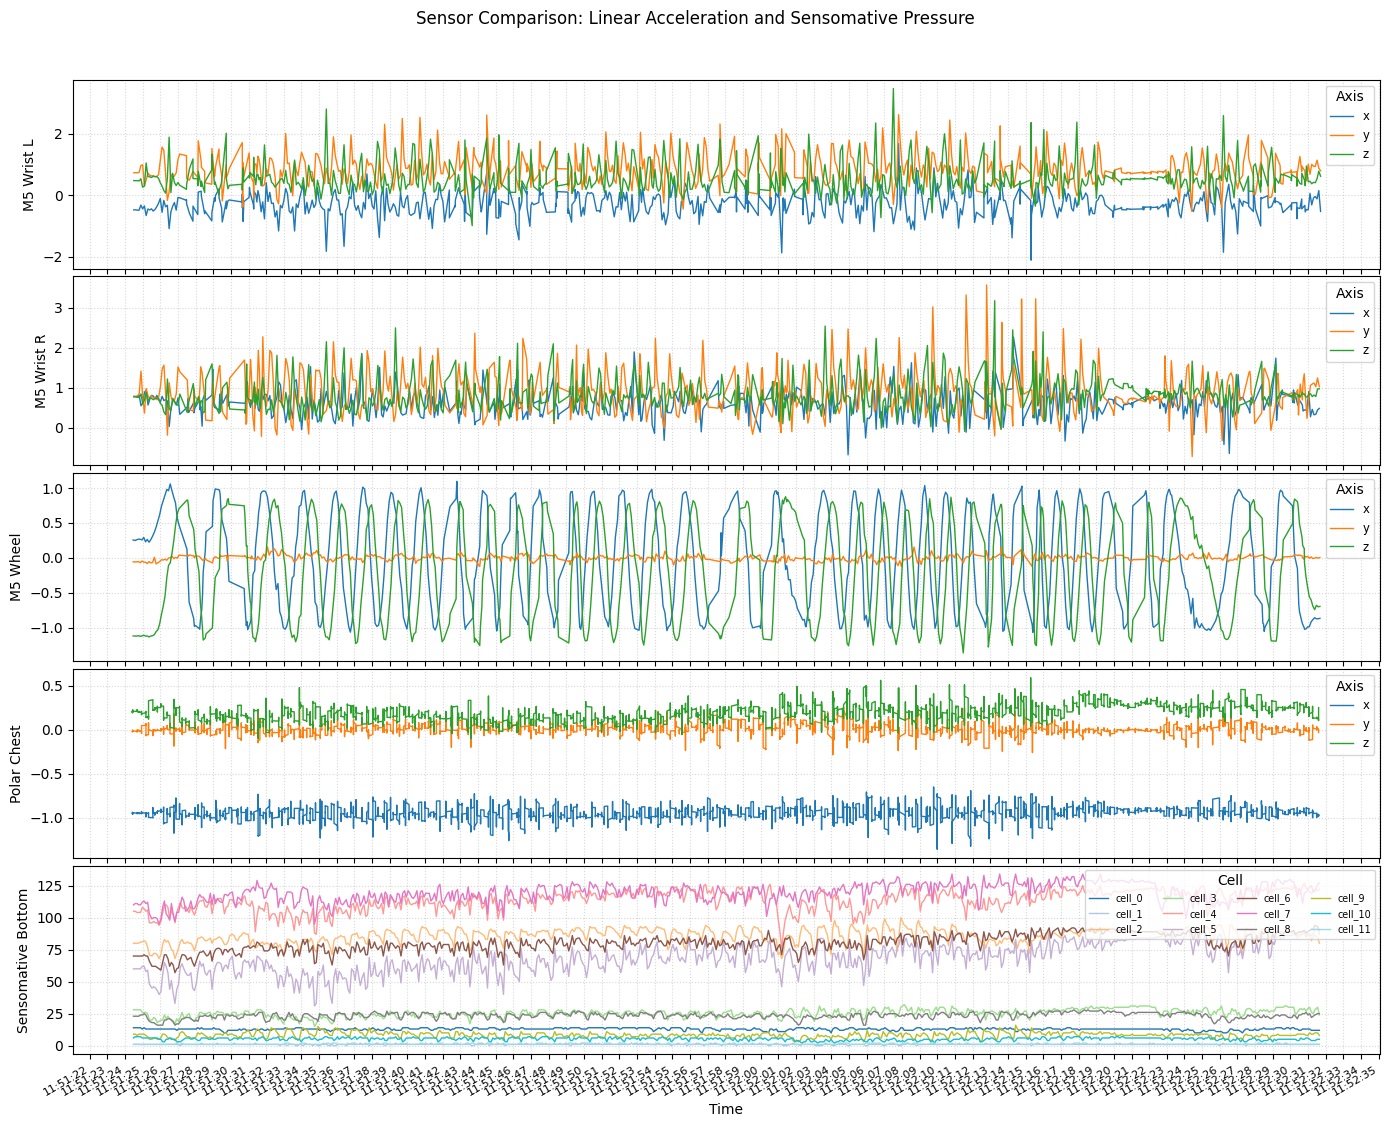

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Sensor data and labels (using your new variable names)
sensor_data = [
    ("M5 Wrist L", m5_wrist_l, "linear_acceleration", ["linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z"], {"x": "tab:blue", "y": "tab:orange", "z": "tab:green"}),
    ("M5 Wrist R", m5_wrist_r, "linear_acceleration", ["linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z"], {"x": "tab:blue", "y": "tab:orange", "z": "tab:green"}),
    ("M5 Wheel", m5_wheel, "linear_acceleration", ["linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z"], {"x": "tab:blue", "y": "tab:orange", "z": "tab:green"}),
    ("Polar Chest", polar_chest, "linear_acceleration", ["linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z"], {"x": "tab:blue", "y": "tab:orange", "z": "tab:green"}),
    ("Sensomative Bottom", sensomative_bottom, "pressure", [f"pressure_{i}" for i in range(12)], None),  # All 12 cells
]

n_sensors = len(sensor_data)
fig, axes = plt.subplots(n_sensors, 1, figsize=(14, 2.2 * n_sensors), sharex=True)

if n_sensors == 1:
    axes = [axes]

for ax, (sensor_name, parsed, modality_key, cols, color_map) in zip(axes, sensor_data):
    if modality_key in parsed:
        df = parsed[modality_key]
        if sensor_name != "Sensomative Bottom":
            for axis, col in zip(["x", "y", "z"], cols):
                if col in df.columns:
                    ax.plot(df["datetime"], df[col], label=axis, color=color_map[axis], linewidth=1)
            ax.legend(title="Axis", loc="upper right", fontsize="small")
        else:
            # Use a colormap for 12 pressure cells (updated for matplotlib >=3.7)
            colors = plt.get_cmap('tab20', 12)
            for i, col in enumerate(cols):
                if col in df.columns:
                    ax.plot(df["datetime"], df[col], label=f"cell_{i}", color=colors(i), linewidth=1)
            ax.legend(title="Cell", loc="upper right", fontsize="x-small", ncol=4)
        ax.set_ylabel(sensor_name)
    else:
        ax.set_ylabel(sensor_name)
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
    ax.grid(True, linestyle=":", alpha=0.5)

# Set x-ticks every 1 second and format
axes[-1].xaxis.set_major_locator(mdates.SecondLocator(interval=1))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

for label in axes[-1].get_xticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment('right')
    label.set_fontsize(8)

axes[-1].set_xlabel("Time")
plt.suptitle("Sensor Comparison: Linear Acceleration and Sensomative Pressure", y=1.02)
plt.tight_layout(h_pad=0.2)
plt.show()